##  Train and evaluate a simple object detector

**0) Loading**
* To make changes in the Colab, copy it in your Google Drive under  **File** (in the left menu) --> *Save a copy in Drive*
* Select a GPU/TPU under **Runtime** (in the upper menu) --> *Change Runtime type --> GPU with Python3*
* Upload the zip folder called *selected_imgs.zip* in the current folder of the Colab through **Files** (in the left menu) -->*Upload*
* Upload the image *minion-white.jpg* that we will use to create our dataset
* Run the commands below to unzip the images and import modules

PS: Every time you close the notebook, you'll need to follow all these steps again


# New Section

In [0]:
# the input dataset named as 'selected_imgs.zip'
# this is some selected images of LSUN dataset
# everytime you make a new colab session you need to upload and the extract it.
!unzip selected_imgs.zip

Archive:  selected_imgs.zip
   creating: selected_imgs/
  inflating: selected_imgs/348.png   
   creating: __MACOSX/
   creating: __MACOSX/selected_imgs/
  inflating: __MACOSX/selected_imgs/._348.png  
  inflating: selected_imgs/1186.png  
  inflating: __MACOSX/selected_imgs/._1186.png  
  inflating: selected_imgs/412.png   
  inflating: __MACOSX/selected_imgs/._412.png  
  inflating: selected_imgs/374.png   
  inflating: __MACOSX/selected_imgs/._374.png  
  inflating: selected_imgs/360.png   
  inflating: __MACOSX/selected_imgs/._360.png  
  inflating: selected_imgs/406.png   
  inflating: __MACOSX/selected_imgs/._406.png  
  inflating: selected_imgs/1192.png  
  inflating: __MACOSX/selected_imgs/._1192.png  
  inflating: selected_imgs/1179.png  
  inflating: __MACOSX/selected_imgs/._1179.png  
  inflating: selected_imgs/1145.png  
  inflating: __MACOSX/selected_imgs/._1145.png  
  inflating: selected_imgs/1151.png  
  inflating: __MACOSX/selected_imgs/._1151.png  
  inflating: select

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import os
from PIL import Image, ImageDraw
import math

**1) Dataset preparation:** 
* Add to the images the target patch ** minion-white.jpg*. We will use random transformations (horizontal flip, translation, rotation, saturation etc..) to create our dataset for patch recognition.(Minions or whatever you like)
* Reshape and normalize the image data to mean 0 and std 1
* Split training and test set

In [0]:
# The desired transformation used for data augmentation
import torchvision.transforms as transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(math.pi/6, translate=None, shear=None, resample=False, fillcolor='white'),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
])
transform_bg = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
])

In [0]:
# data preparation (it will take some time, be patient)
num_imgs = 20000

img_size = 100 
img_size_w = 80
img_size_h = 60
min_object_size = 10
max_object_size = 40 
num_objects = 1
i_object = 0
num_channels = 3


bboxes = np.zeros((num_imgs, num_objects, 5)) #: x, y, w, h, n 
imgs = np.ones((num_imgs, img_size_w, img_size_h, num_channels))    # set background to 0


target_img = Image.open('minion-white.jpg', 'r').convert("RGB")
img_w, img_h = target_img.size
scale = img_w / img_h

# load images and resize them
src_path = './selected_imgs/'
img_list_dir = os.listdir(src_path)
img_list = [names for names in img_list_dir if names.endswith(".png")]
img_list_size = len(img_list)
for i in range(num_imgs):

    ii = img_list[np.random.randint(0, img_list_size)]
    background = Image.open(src_path+ii).convert("RGB")
    #background = transform_bg(background)
    bg_w, bg_h = background.size
    
    # add target image
    is_bbox = np.random.rand() > 0.5
    if (is_bbox == False):
        x,y,h,w,x2,y2,h2,w2=0, 0, 0, 0, 0, 0, 0, 0
    else:
        h = np.random.randint(min_object_size, max_object_size)
        w = int(h*scale)
        target_img_i = target_img.copy()
        target_img_i = transform_train(target_img_i)
        target_img_i = target_img_i.resize((w,h))
        x = np.random.randint(0, img_size_w - w)
        y = np.random.randint(0, img_size_h - h)

        #draw = ImageDraw.Draw(background)
        #draw.rectangle(((x,y),(x+w,y+h)), fill="white")
        background.paste(target_img_i, (x,y))

    imgs[i] = np.asarray(background).transpose(1,0,2)/255
    bboxes[i, i_object] = [x+w//2, y+h//2, w, h, is_bbox]
        
imgs.shape, bboxes.shape

((20000, 80, 60, 3), (20000, 1, 5))

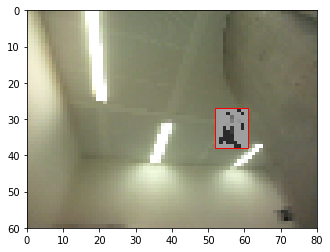

In [0]:
# one example of what we did (run it multiple times)
i = np.random.randint(0, num_imgs)
plt.imshow(imgs[i].transpose((1,0,2)), extent=[0, img_size_w, img_size_h, 0])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0]-bbox[2]//2, bbox[1]-bbox[3]//2), bbox[2], bbox[3], ec='r', fc='none'))

In [0]:
# Reshape and normalize the image data to mean 0 and std 1. 
imgs_mean = np.mean(imgs,axis=(0,1,2)).reshape((1,1,1,-1))
imgs_std = np.std(imgs,axis=(0,1,2)).reshape((1,1,1,-1))
print(imgs_mean,imgs_std)
X = (imgs - imgs_mean) / imgs_std #.reshape(num_imgs, -1)
print(X.shape, np.mean(X), np.std(X))

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1).copy()
y[:,0:4] = y[:,0:4]/img_size
print(y.shape, np.mean(y), np.std(y))

[[[[0.54136277 0.56135976 0.5151562 ]]]] [[[[0.27707013 0.28022748 0.27258835]]]]
(20000, 80, 60, 3) 1.5305499470091236e-11 0.9999999999586133
(20000, 5) 0.21461490000000003 0.30672897759747125


In [0]:
# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]
train_bboxes = bboxes[:i]

**2) Define the Neural Network**
* Choose the hyperparameters
* Define the network architecture

In [0]:
# network hyperparameters
batch_size = 100
num_epoch = 10
learning_rate = 0.001

In [0]:
# define network architecture
import torch
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_c):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.box = torch.nn.Linear(n_hidden, n_output-1)   # output layer
        self.logit = torch.nn.Linear(n_hidden, 1)
        
        self.conv1 = torch.nn.Sequential(         # input shape (3, 80, 60)
            torch.nn.Conv2d(
                in_channels = n_c,            # input height
                out_channels = 8,             # n_filters
                kernel_size = 5,              # filter size
                stride = 2,                   # filter movement/step
                padding = 0,                  
            ),                              
            torch.nn.ReLU(),                      # activation
            #torch.nn.MaxPool2d(kernel_size = 2),    
        )
        self.conv2 = torch.nn.Sequential(       
            torch.nn.Conv2d(in_channels = 8, 
                            out_channels = 16, 
                            kernel_size = 5, 
                            stride = 2, 
                            padding = 0),      
            torch.nn.ReLU(),                      # activation
            #torch.nn.MaxPool2d(2),                
        )
        
        self.conv3 = torch.nn.Sequential(       
            torch.nn.Conv2d(in_channels = 16, 
                            out_channels = 8, 
                            kernel_size = 1, 
                            stride = 1, 
                            padding = 0),      
            torch.nn.ReLU(),                      # activation
            #torch.nn.MaxPool2d(2),                
        )
    def forward(self, x):
        feat = self.conv1(x)
        feat = self.conv2(feat)
        feat = self.conv3(feat)
        feat = feat.view(feat.size(0), -1)
        x2 = F.relu(self.hidden(feat))      # activation function for hidden layer
        
        out_box = F.relu(self.box(x2))            # linear output
        out_logit = torch.sigmoid(self.logit(x2))
        
        return out_box, out_logit
      
net = Net(n_feature = 1632, n_hidden = 128, n_output = 5, n_c = num_channels)     # define the network
print(net)  # net architecture

Net(
  (hidden): Linear(in_features=1632, out_features=128, bias=True)
  (box): Linear(in_features=128, out_features=4, bias=True)
  (logit): Linear(in_features=128, out_features=1, bias=True)
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
)


**3) Define the evaluation metric**

The accuracy of the network will be calculated based on the Intersection over Union between 2 rectangles: the predicted one and the ground truth one. 

In this section, you will need to write a function which  takes 2 boxes as input and returns the IOU Score.

*Hints*: 

*   $0 \le IOU score \le 1$
* For the intersection you need to find the coordinates of the intersection of two boxes
* After calculating the intersection, you have all the elements to compute the union
*  Don't forget the case where the two boxes are not overlapping at all




In [0]:
def calculate_IOU(bbox1, bbox2):
    #Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity
    
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]
    
    # Note that (x1,y1) and (x2,y2) are the centers...
    
    x11 = x1 - w1/2
    x12 = x1 + w1/2
    y11 = y1 - h1/2
    y12 = y1 + h1/2

    x21 = x2 - w2/2
    x22 = x2 + w2/2
    y21 = y2 - h2/2
    y22 = y2 + h2/2
    
    xA = max(x11, x21)
    yA = max(y11, y21)
    xB = min(x12, x22)
    yB = min(y12, y22)

    # (Approximately 5 lines)
    intersection = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = (x12 - x11) * (y12 - y11)
    boxBArea = (x22 - x21) * (y22 - y21)

    # (1 line)
    union = (boxAArea + boxBArea - intersection)
    
    return intersection / union

In [35]:
# Test the IOU
box1 = [2, 3, 10, 20]
box2 = [4, 1, 5, 25]
iou = calculate_IOU(box1, box2)
print("Correct IOU: 0.4444444444444444")
print("Your IOU: {}".format(iou))

Correct IOU: 0.4444444444444444
Your IOU: 0.4444444444444444


In [0]:
# This function used the computed IOU to calculate the accuracy of the neural network
def calculate_accuracy(pred_class, pred_bboxes, test_bboxes):
    # Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
    summed_IOU = 0.
    l =0
    for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 5)):
        if(test_bbox[4]==1): # the ones that have black boxes
            summed_IOU += calculate_IOU(pred_bbox, test_bbox)
            l+=1
    mean_IOU = summed_IOU / l
    print("mean IOU: ", mean_IOU)

    # classification accuracy
    print("classification acc: ", np.mean(test_bboxes[:,0,4:]==pred_class))
    

**4) Define the loss function and the weight *gamma* **

Until now we defined how to evaluate our network. We also need to define the loss function to train it. In this case, it will be a linear composition of 2 terms:

*  A classification term for the presence or absence of a target patch in the image
*  A regression term for each of the box corners

In [0]:
# Instanciate the loss functions using PyTorch predefined functions(2 lines)
# Get familiar with PyTorch documentation at *https://pytorch.org/docs/stable/nn.html*

regression_criterion = torch.nn.MSELoss()
classification_criterion = torch.nn.BCELoss()  # Hint: Consider that we only one class to predict

You also need to define a weight for the 2 loss function which specified a trade-off between classification and regression. This avoids one loss to play the biggest role in the training phase.

You can do that iteratively: try with a simple value (e.g. *gamma=0.5*), complete the next session and run the training phase of the model. At the first epoch, you can already see the relative values of the two loss functions. If you are not satisfied, stop the training (it requires 5 minutes to run) and change the value of gamma. 

In [0]:
# (Iteratively) define the weight of the 2 losses (1 line)
gamma = 0.001

**5) Train the network**

In the following part you need to specify how to combine the 2 loss functions using the weight gamma.
Then, the training can start, let's see how it goes! 

In [47]:
# Instanciate the network and define the optimizer
net = Net(n_feature = 1632, n_hidden = 128, n_output = 5, n_c = num_channels)
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

# train loop
if(train_X.shape[1]!=num_channels): #dim1==channel
    train_X = train_X.transpose((0,3,1,2))
n_batch = train_X.shape[0]//batch_size

for epoch in range(num_epoch):
    for batch in range(n_batch):
        batch_X = train_X[batch*batch_size:min((batch+1)*batch_size, train_X.shape[0])]
        batch_y = train_y[batch*batch_size:min((batch+1)*batch_size, train_X.shape[0])]
        out_box, out_logit = net(torch.tensor(batch_X, dtype=torch.float32))
        
        mask_arr = np.argwhere(batch_y[:,-1]==1).reshape((-1,))
        regression_loss = regression_criterion(out_box[mask_arr], torch.tensor(batch_y[mask_arr,:-1], dtype=torch.float32))
        classification_loss = classification_criterion(out_logit, torch.tensor(batch_y[:,-1:], dtype=torch.float32))
        
        # Compose the 2 loss functions using the weight gamma (1 line)
        loss = regression_loss * (1-gamma) + classification_loss * gamma
        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    
    print('epoch: {}  Total loss -> {:.5f}   classif_loss -> {:.5f}  regress_loss -> {:.5f}'
          .format(epoch, loss.item(), classification_loss.item(), regression_loss.item()))

epoch: 0  Total loss -> 0.00471   classif_loss -> 0.64879  regress_loss -> 0.00406
epoch: 1  Total loss -> 0.00214   classif_loss -> 0.45361  regress_loss -> 0.00168
epoch: 2  Total loss -> 0.00180   classif_loss -> 0.31868  regress_loss -> 0.00149
epoch: 3  Total loss -> 0.00131   classif_loss -> 0.23405  regress_loss -> 0.00108
epoch: 4  Total loss -> 0.00095   classif_loss -> 0.18157  regress_loss -> 0.00077
epoch: 5  Total loss -> 0.00077   classif_loss -> 0.14819  regress_loss -> 0.00062
epoch: 6  Total loss -> 0.00063   classif_loss -> 0.12442  regress_loss -> 0.00050
epoch: 7  Total loss -> 0.00053   classif_loss -> 0.10627  regress_loss -> 0.00042
epoch: 8  Total loss -> 0.00045   classif_loss -> 0.09292  regress_loss -> 0.00036
epoch: 9  Total loss -> 0.00040   classif_loss -> 0.08138  regress_loss -> 0.00032


** 6) Predict accuracy **

Great job, the model is now trained! Let's check the accuracy in our training and test set

In [48]:
# Predict bounding boxes on the train images.

if(train_X.shape[1]!=num_channels):
    train_X = train_X.transpose((0,3,1,2))
# Predict bounding boxes on the train images.
with torch.no_grad():
    pred_y_train_box, pred_y_train_logit = net.forward(torch.tensor(train_X, dtype=torch.float32))
    pred_y_train_box, pred_y_train_logit = pred_y_train_box.numpy(), pred_y_train_logit.numpy()
    pred_y_train_label = pred_y_train_logit>0.5
    pred_bboxes_train = pred_y_train_box * img_size
    pred_bboxes_train = pred_bboxes_train.reshape(len(pred_bboxes_train), num_objects, -1)
    pred_bboxes_train.shape

calculate_accuracy(pred_y_train_label, pred_bboxes_train, train_bboxes)

mean IOU:  0.7445271309845719
classification acc:  0.9823125


In [49]:
# Predict bounding boxes on the test images.

if(test_X.shape[1]!=num_channels):
    test_X = test_X.transpose((0,3,1,2))
with torch.no_grad():
    pred_y_box, pred_y_logit = net.forward(torch.tensor(test_X, dtype=torch.float32))
    pred_y_box, pred_y_logit = pred_y_box.numpy(), pred_y_logit.numpy()
    pred_y_label = pred_y_logit>0.5
    pred_bboxes = pred_y_box * img_size
    pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
    pred_bboxes.shape

calculate_accuracy(pred_y_label, pred_bboxes, test_bboxes)

mean IOU:  0.7077218951522334
classification acc:  0.981


**Note: ** A good accuracy is around 0.65 - 0.7 for *mean IOU*. You can always come back and try different *gamma*

** 7) Visualization **

It is always good practice to visualize the results of our network on few images

In [0]:
def plot_few_images(pred_label, pred_bboxes, test_bboxes, test_imgs):
    # Show a few images and predicted bounding boxes from the test dataset. 
    plt.figure(figsize=(12, 3))
    for i_subplot in range(1, 5):
        plt.subplot(1, 4, i_subplot)
        i = np.random.randint(len(test_imgs))
        plt.imshow(test_imgs[i], extent=[0, img_size_w, img_size_h, 0])
        
        for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
            if(pred_label[i]): # the ones that have been classified as having black boxes
                plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0]-pred_bbox[2]//2, pred_bbox[1]-pred_bbox[3]//2), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
                plt.annotate('IOU: {:.2f}'.format(calculate_IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')

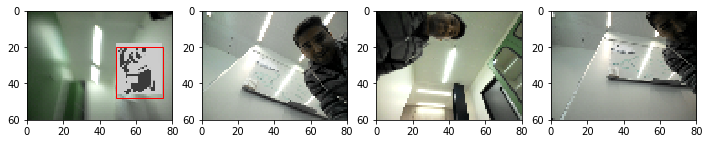

In [51]:
plot_few_images(pred_y_label, pred_bboxes, test_bboxes, test_imgs.transpose(0,2,1,3))

** 8) Save and Download the model **

Now that you have trained your model, save it with the following snippet. 

In [52]:
# save
torch.save(net.state_dict(), 'saved_model.pth') # this will save the model in the desired path
# restore
net = Net(n_feature = 1632, n_hidden = 128, n_output = 5, n_c = num_channels) # define the model again to be restored
net.load_state_dict(torch.load('saved_model.pth')) # this will load it
net.eval()

Net(
  (hidden): Linear(in_features=1632, out_features=128, bias=True)
  (box): Linear(in_features=128, out_features=4, bias=True)
  (logit): Linear(in_features=128, out_features=1, bias=True)
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
)

To continue with the next part of your practical, you need to download locally the model *saved_model.pth*  from google Colab by clicking on it in the left menu under 'Files' section.

**That's it for the first part. Congratulations for developing a simple object detector!**
